In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.cluster import DBSCAN,KMeans
from sklearn.metrics import silhouette_score,homogeneity_score,completeness_score
from sklearn.neighbors import kneighbors_graph

from sklearn.model_selection import train_test_split
from scipy.special import comb
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def within_cluster(x, labels):
    distance = 0
    for i in range(10):
        cluster_points = x[labels == i]
        for j in cluster_points:
            for k in cluster_points:
                distance += np.sqrt(np.sum( (j - k) ** 2))
    return distance

def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

def column_string_to_int(data, column, n_hash_features):
    data[column].unique()[0:100]
    single_genre = data[data[column].apply(lambda x: x.find(',') == -1)][column].unique()
    print(single_genre.shape)
    fh = FeatureHasher(n_features = n_hash_features, input_type='string')
    fh.fit(single_genre)
    hashed_features = data[column].apply(lambda x: np.sum(fh.transform(np.array([x])).toarray(),axis = 0) 
                                          if x in single_genre
                                          else np.sum(fh.transform(x.split(',')).toarray(), axis = 0)).values

    hashed_features = np.vstack(hashed_features)
    data.drop(columns=[column], inplace = True)
    columns = list()
    for i in range(n_hash_features):
        columns.append(column + "_" + str(i))
    df = pd.DataFrame(hashed_features, columns=columns)
    data = data.join(df)
    return data

COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan', 'tab:gray']
MARKERS = ['o', 'v', 's', '<', '>', '8', '^', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

def plot2d(X, y_pred, y_true, mode=None, centroids=None):
    transformer = None
    X_r = X
    
    if mode is not None:
        transformer = mode(n_components=2)
        X_r = transformer.fit_transform(X)

    assert X_r.shape[1] == 2, 'plot2d only works with 2-dimensional data'


    plt.grid()
    for ix, iyp, iyt in zip(X_r, y_pred, y_true):
        plt.plot(ix[0], ix[1], 
                    c=COLORS[iyp], 
                    marker=MARKERS[iyt])
        
    if centroids is not None:
        C_r = centroids
        if transformer is not None:
            C_r = transformer.fit_transform(centroids)
        for cx in C_r:
            plt.plot(cx[0], cx[1], 
                        marker=MARKERS[-1], 
                        markersize=10,
                        c='red')

    plt.show()

def plot3d(X, y_pred, y_true, mode=None, centroids=None):
    transformer = None
    X_r = X
    if mode is not None:
        transformer = mode(n_components=3)
        X_r = transformer.fit_transform(X)

    assert X_r.shape[1] == 3, 'plot2d only works with 3-dimensional data'

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.elev = 30
    ax.azim = 120

    for ix, iyp, iyt in zip(X_r, y_pred, y_true):
        ax.plot(xs=[ix[0]], ys=[ix[1]], zs=[ix[2]], zdir='z',
                    c=COLORS[iyp], 
                    marker=MARKERS[iyt])
        
    if centroids is not None:
        C_r = centroids
        if transformer is not None:
            C_r = transformer.fit_transform(centroids)
        for cx in C_r:
            ax.plot(xs=[cx[0]], ys=[cx[1]], zs=[cx[2]], zdir='z',
                        marker=MARKERS[-1], 
                        markersize=10,
                        c='red')
    plt.show()
    
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    #text = re.sub('\W', ' ', text)
    #text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [3]:
movies = pd.read_csv("wiki_movie_plots_deduped.csv")
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
movies.nunique()

Release Year          117
Title               32432
Origin/Ethnicity       24
Director            12593
Cast                32182
Genre                2265
Wiki Page           34070
Plot                33869
dtype: int64

In [5]:
print(movies['Plot'][10])
print(movies['Plot'][11])
print(movies['Plot'][12])

The Rarebit Fiend gorges on Welsh rarebit at a restaurant. When he leaves, he begins to get dizzy as he starts to hallucinate. He desperately tries to hang onto a lamppost as the world spins all around him. A man helps him get home. He falls into bed and begins having more hallucinatory dreams. During a dream sequence, the furniture begins moving around the room. Imps emerge from a floating Welsh rarebit container and begin poking his head as he sleeps. His bed then begins dancing and spinning wildly around the room before flying out the window with the Fiend in it. The bed floats across the city as the Fiend floats up and off the bed. He hangs off the back and eventually gets caught on a weathervane atop a steeple. His bedclothes tear and he falls from the sky, crashing through his bedroom ceiling. The Fiend awakens from the dream after falling out of his bed.
The film features a train traveling through the Rockies and a hold up created by two thugs placing logs on the line. They syst

In [6]:
movies.drop(columns=['Wiki Page', 'Title'], inplace = True)
movies.isnull().sum()

Release Year           0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Plot                   0
dtype: int64

In [7]:
print(len(movies.loc[movies['Director'] == 'Unknown'].index))
movies = movies[pd.notnull(movies['Cast'])]
movies = movies[movies['Director'] != 'Unknown']
movies = movies[movies['Genre'] != 'unknown']
len(movies)

1124


27832

In [8]:
movies['Count']=1
movies[['Genre','Count']].groupby(['Genre'], as_index=False).count().shape[0]

2191

In [9]:
# harmonization
movies['GenreCorrected'] =movies['Genre'] 
movies['GenreCorrected']=movies['GenreCorrected'].str.strip()
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' - ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' / ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('/', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' & ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(', ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('; ', '|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-pic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biopic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographical', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biodrama', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bio-drama', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biographic', 'biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(film genre\)', '')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animated','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('anime','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('children\'s','children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedey','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[not in citation given\]','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' set 4,000 years ago in the canadian arctic','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historical','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romantic','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3-d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('3d','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('viacom 18 motion pictures','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci-fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('ttriller','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('.','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('based on radio serial','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' on the early years of hitler','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sci fi','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science fiction','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' (30min)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('16 mm film','short')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[140\]','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\[144\]','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' for ','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventures','adventure')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('kung-fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial arts','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war ii','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('world war i','war')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography about montreal canadiens star|maurice richard','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bholenath movies|cinekorn entertainment','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(volleyball\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('spy film','spy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('anthology film','anthology')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography fim','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('avant-garde','avant_garde')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biker film','biker')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('buddy cop','buddy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('buddy film','buddy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedy 2-reeler','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('films','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('film','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('british-german co-production','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('bruceploitation','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movies by the mob\|knkspl','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movies','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('movie','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming of age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('coming-of-age','coming_of_age')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('drama about child soldiers','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( based).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( co-produced).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( adapted).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( about).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('musical b','musical')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animationchildren','animation|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' period','period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('drama loosely','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("war-time","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wartime","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("ww1","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('unknown','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace("wwii","war")
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psychological','psycho')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('rom-coms','romance')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('true crime','crime')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|007','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('slice of life','slice_of_life')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('computer animation','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gun fu','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('j-horror','horror')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(shogi|chess\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('afghan war drama','war drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|6 separate stories','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(30min\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' (road bicycle racing)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' v-cinema','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('tv miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|docudrama','\|documentary|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' in animation','|animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adaptation).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adaptated).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((adapted).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('(( on ).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('american football','sports')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dev\|nusrat jahan','sports')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('television miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(artistic\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \|direct-to-dvd','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('history dram','history drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial art','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('psycho thriller,','psycho thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|1 girl\|3 suitors','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' \(road bicycle racing\)','')
filterE = movies['GenreCorrected']=="ero"
movies.loc[filterE,'GenreCorrected']="adult"
filterE = movies['GenreCorrected']=="music"
movies.loc[filterE,'GenreCorrected']="musical"
filterE = movies['GenreCorrected']=="-"
movies.loc[filterE,'GenreCorrected']=''
filterE = movies['GenreCorrected']=="comedy–drama"
movies.loc[filterE,'GenreCorrected'] = "comedy|drama"
filterE = movies['GenreCorrected']=="comedy–horror"
movies.loc[filterE,'GenreCorrected'] = "comedy|horror"
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(' ','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace(',','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('-','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionadventure','action|adventure')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actioncomedy','action|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actiondrama','action|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionlove','action|love')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionmasala','action|masala')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionchildren','action|children')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasychildren\|','fantasy|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasycomedy','fantasy|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantasyperiod','fantasy|period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('cbctv_miniseries','tv_miniseries')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramacomedy','drama|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramacomedysocial','drama|comedy|social')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramathriller','drama|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedydrama','comedy|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramathriller','drama|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedyhorror','comedy|horror')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sciencefiction','science_fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventurecomedy','adventure|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('animationdrama','animation|drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\|','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('muslim','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('thriler','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('crimethriller','crime|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('fantay','fantasy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionthriller','action|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedysocial','comedy|social')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martialarts','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\(children\|poker\|karuta\)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('epichistory','epic|history')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotica','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('erotic','adult')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('((\|produced\|).+)','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('chanbara','chambara')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('comedythriller','comedy|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biblical','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biblical','religious')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('colour\|yellow\|productions\|eros\|international','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|directtodvd','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('liveaction','live|action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('melodrama','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroes','superheroe')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('gangsterthriller','gangster|thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('heistcomedy','comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('heist','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historic','history')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('historydisaster','history|disaster')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('warcomedy','war|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('westerncomedy','western|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('ancientcostume','costume')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('computeranimation','animation')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramatic','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familya','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familya','family')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramedy','drama|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('dramaa','drama')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('famil\|','family')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superheroe','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('biogtaphy','biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('devotionalbiography','devotional|biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('docufiction','documentary|fiction')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('familydrama','family|drama')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('espionage','spy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('supeheroes','superhero')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancefiction','romance|fiction')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('horrorthriller','horror|thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('suspensethriller','suspense|thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('musicaliography','musical|biography')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('triller','thriller')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|\(fiction\)','|fiction')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romanceaction','romance|action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancecomedy','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romancehorror','romance|horror')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romcom','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('rom\|com','romance|comedy')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('satirical','satire')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science_fictionchildren','science_fiction|children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('homosexual','adult')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('sexual','adult')

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('mockumentary','documentary')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('periodic','period')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('romanctic','romantic')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('politics','political')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('samurai','martial_arts')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('tv_miniseries','series')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('serial','series')

filterE = movies['GenreCorrected']=="musical–comedy"
movies.loc[filterE,'GenreCorrected'] = "musical|comedy"

filterE = movies['GenreCorrected']=="roman|porno"
movies.loc[filterE,'GenreCorrected'] = "adult"


filterE = movies['GenreCorrected']=="action—masala"
movies.loc[filterE,'GenreCorrected'] = "action|masala"


filterE = movies['GenreCorrected']=="horror–thriller"
movies.loc[filterE,'GenreCorrected'] = "horror|thriller"

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('family','children')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('martial_arts','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('horror','thriller')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('war','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('adventure','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('science_fiction','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('western','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('western','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('noir','black')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('spy','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('superhero','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('social','')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('suspense','action')


filterE = movies['GenreCorrected']=="drama|romance|adult|children"
movies.loc[filterE,'GenreCorrected'] = "drama|romance|adult"

movies['GenreCorrected']=movies['GenreCorrected'].str.replace('\|–\|','|')
movies['GenreCorrected']=movies['GenreCorrected'].str.strip(to_strip='\|')
movies['GenreCorrected']=movies['GenreCorrected'].str.replace('actionner','action')
movies['GenreCorrected']=movies['GenreCorrected'].str.strip()

movies['Plot'] = movies['Plot'].apply(clean_text)

In [10]:
moviesGenre = movies[['GenreCorrected','Count']].groupby(['GenreCorrected']).count()
movies['GenreSplit']=movies['GenreCorrected'].str.split('|')
movies['GenreSplit']= movies['GenreSplit'].apply(np.sort).apply(np.unique)

genres_array = np.array([])

for i, row in movies.iterrows():
    genres_array = np.concatenate((genres_array, row['GenreSplit']))
genres = pd.DataFrame({'Genre':genres_array})
genres['Count']=1
genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False)
genres = genres[genres['Genre']!='']
TotalCountGenres=sum(genres['Count'])
genres['Frequency'] = genres['Count']/TotalCountGenres
genres['CumulativeFrequency'] = genres['Frequency'].cumsum()
mainGenres = np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])
unique_genres = np.unique(mainGenres)
movies = movies[movies['GenreCorrected'].apply(lambda x : x in unique_genres)]
freq_genres = movies['GenreCorrected'].value_counts(normalize=True)
movies = movies[movies['GenreCorrected'].apply(lambda x : freq_genres[x] > 0.03)]
movies.drop(['GenreSplit','Genre'], axis = 1, inplace = True)
movies.nunique()

Release Year          111
Origin/Ethnicity       24
Director             7051
Cast                16620
Plot                16913
Count                   1
GenreCorrected          5
dtype: int64

In [11]:
freq_genres = movies[['GenreCorrected', 'Count']].groupby(['GenreCorrected'], as_index = False).sum().sort_values(['Count'], ascending=False)
freq_dict = dict(zip(freq_genres['GenreCorrected'], freq_genres['Count'] * 0.15))
frames = []
for key, value in freq_dict.items():
    g = movies[movies['GenreCorrected'] == key].sample(int(value))
    frames.append(g)
movies = pd.concat(frames).sample(frac=1)
movies.nunique()

Release Year         108
Origin/Ethnicity      23
Director            1850
Cast                2539
Plot                2553
Count                  1
GenreCorrected         5
dtype: int64

In [12]:
le = preprocessing.LabelEncoder()
movies.drop('Count', axis = 1, inplace=True)
movies['Origin/Ethnicity'] = le.fit_transform(movies['Origin/Ethnicity'])
movies['Director'] = le.fit_transform(movies['Director'])
movies['GenreCorrected'] = le.fit_transform(movies['GenreCorrected'])
movies['Cast'] = le.fit_transform(movies['Cast'])
X = movies['Plot'].values
y = movies['GenreCorrected']
movies.drop(columns=['Plot'], inplace = True)
movies = (movies - movies.min()) / (movies.max() - movies.min())
movies.isnull().sum()

Release Year        0
Origin/Ethnicity    0
Director            0
Cast                0
GenreCorrected      0
dtype: int64

In [13]:
vectorizer = TfidfVectorizer(max_df =0.9, strip_accents='ascii', stop_words='english',analyzer='word',
                              token_pattern=r'(?u)\b[A-Za-z]+\b',norm = 'l2',sublinear_tf = False)
X_vectorized = vectorizer.fit_transform(X).toarray()
X_vectorized = np.array(X_vectorized)
X_vectorized.shape

(2556, 37396)

In [14]:
X_data = movies.values
X = np.concatenate([X_data,X_vectorized], axis = 1)
transformer = PCA(n_components= 20)
X_PCA = transformer.fit_transform(X)

In [15]:
kk = np.array([3,4,5,6])

report = []
for k in kk:
    for i,method in enumerate(['k-means++', 'random']):
        model = KMeans(n_clusters = k, init = method, n_jobs = -1)
        model.fit(X)
        report.append([method,k,model.inertia_, within_cluster(X,model.labels_),silhouette_score(X,model.labels_),homogeneity_score(y,model.labels_),completeness_score(y,model.labels_)])

hyperparameters_scores = pd.DataFrame(report,columns = ('init','nr_clusters','inertia','W','silhouette_score','homogenity_score','completeness_score'))
hyperparameters_scores

,init,nr_clusters,inertia,W,silhouette_score,homogenity_score,completeness_score
0,k-means++,3,3234.304406,4.508842e+06,0.053511,0.240129,0.372771
1,random,3,3234.305539,4.506445e+06,0.053493,0.240278,0.372895
2,k-means++,4,3123.479597,3.111845e+06,0.050101,0.253026,0.292061
3,random,4,3123.425388,3.111704e+06,0.050094,0.258335,0.298149
4,k-means++,5,3053.184109,2.217415e+06,0.043730,0.261889,0.246591
5,random,5,3053.193722,2.216305e+06,0.043694,0.262027,0.246699
6,k-means++,6,3008.882340,1.732469e+06,0.039833,0.259444,0.214710
7,random,6,3008.886408,1.733267e+06,0.039858,0.260761,0.215838


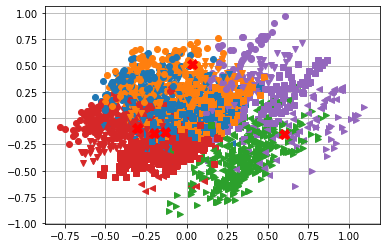

In [16]:
model = KMeans(n_clusters = 5 , init ='random', n_jobs = -1).fit(X)
plot2d(X, model.labels_, y, mode=PCA, centroids=model.cluster_centers_)

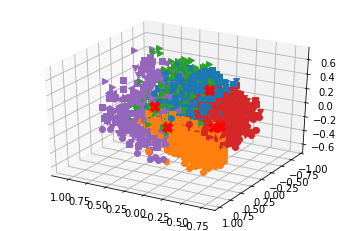

In [17]:
plot3d(X, model.labels_, y, mode=PCA, centroids=model.cluster_centers_)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = True)
model = KMeans(n_clusters = 5, init='k-means++', n_jobs = -1).fit(X_train)
rand_index_score(model.predict(X_test), y_test)

0.6862030774766266

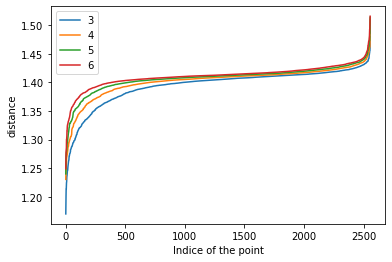

In [19]:
kk = [3, 4, 5, 6]
for k in kk :
    distances = kneighbors_graph(X,k, mode='distance', include_self=False, n_jobs = -1).toarray()
    distances = np.sort(np.sort(distances[distances != 0].reshape(-1,k))[:,k-1])
    plt.plot(range(X.shape[0]),distances)
plt.legend(kk)
plt.xlabel('Indice of the point')
plt.ylabel('distance')
plt.show()


In [35]:
epss = np.array([1.41,1.42,1.43,1.44])

report = []
for eps in epss:
    model = DBSCAN(eps = eps, min_samples = 4, n_jobs = -1)
    model.fit(X)
    n_clusters = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    report.append([eps,n_clusters,within_cluster(X,model.labels_),silhouette_score(X,model.labels_),homogeneity_score(y,model.labels_),completeness_score(y,model.labels_)])

hyperparameters_scores = pd.DataFrame(report,columns = ('eps','n_clusters','W','silhouette_score','homogenity_score','completeness_score'))
hyperparameters_scores

,eps,n_clusters,W,silhouette_score,homogenity_score,completeness_score
0,1.41,10,7.376634e+06,-0.039682,0.021886,0.057571
1,1.42,5,1.009369e+07,-0.023764,0.009848,0.083887
2,1.43,1,1.073791e+07,0.078435,0.001554,0.076259
3,1.44,1,1.080142e+07,0.093799,0.001104,0.114252


In [29]:
best_model = DBSCAN(eps = 1.42, min_samples = 4, n_jobs = -1).fit(X)
labels = best_model.labels_
n_noise_ = list(labels).count(-1)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('')
print("Homogeneity: %0.3f" % homogeneity_score(y, labels))
print("Completeness: %0.3f" % completeness_score(y, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))

Estimated number of clusters: 5
Estimated number of noise points: 70

Homogeneity: 0.010
Completeness: 0.084
Silhouette Coefficient: -0.024


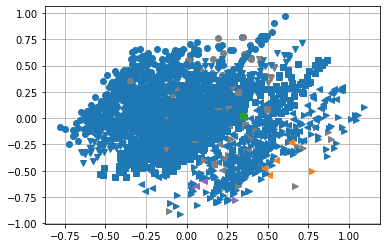

In [30]:
plot2d(X, best_model.labels_, y, mode=PCA)

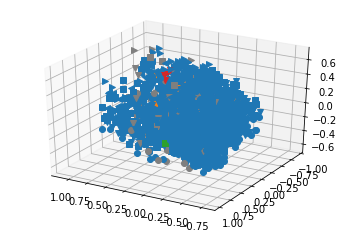

In [31]:
plot3d(X, best_model.labels_, y, mode=PCA)

In [24]:
kk = np.array([3,4,5,6])

report = []
for k in kk:
    for i,method in enumerate(['k-means++', 'random']):
        model = KMeans(n_clusters = k, init = method, n_jobs = -1)
        model.fit(X_PCA)
        report.append([method,k,model.inertia_, within_cluster(X_PCA,model.labels_),silhouette_score(X_PCA,model.labels_),homogeneity_score(y,model.labels_),completeness_score(y,model.labels_)])

hyperparameters_scores = pd.DataFrame(report,columns = ('init','nr_clusters','inertia','W','silhouette_score','homogenity_score','completeness_score'))
hyperparameters_scores

,init,nr_clusters,inertia,W,silhouette_score,homogenity_score,completeness_score
0,k-means++,3,781.811267,2.115632e+06,0.184019,0.242103,0.375618
1,random,3,781.811267,2.115632e+06,0.184019,0.242103,0.375618
2,k-means++,4,671.403885,1.372229e+06,0.195388,0.264821,0.306322
3,random,4,671.403885,1.372229e+06,0.195388,0.264821,0.306322
4,k-means++,5,601.791591,9.309117e+05,0.185233,0.261970,0.246796
5,random,5,601.791591,9.309117e+05,0.185233,0.261970,0.246796
6,k-means++,6,558.197034,7.016951e+05,0.179835,0.260011,0.215136
7,random,6,558.040042,7.104889e+05,0.179841,0.253765,0.210699


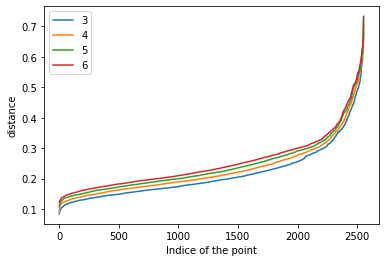

In [26]:
kk = [3, 4, 5, 6]
for k in kk :
    distances = kneighbors_graph(X_PCA,k, mode='distance', include_self=False, n_jobs = -1).toarray()
    distances = np.sort(np.sort(distances[distances != 0].reshape(-1,k))[:,k-1])
    plt.plot(range(X_PCA.shape[0]),distances)
plt.legend(kk)
plt.xlabel('Indice of the point')
plt.ylabel('distance')
plt.show()


In [27]:
best_model = DBSCAN(eps = 0.35, min_samples = 4, n_jobs = -1).fit(X_PCA)
labels = best_model.labels_
n_noise_ = list(labels).count(-1)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('')
print("Homogeneity: %0.3f" % homogeneity_score(y, labels))
print("Completeness: %0.3f" % completeness_score(y, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))

Estimated number of clusters: 4
Estimated number of noise points: 153

Homogeneity: 0.004
Completeness: 0.022
Silhouette Coefficient: -0.054


In [33]:
epss = np.array([0.25,0.3,0.35,0.4])

report = []
for eps in epss:
    model = DBSCAN(eps = eps, min_samples = 4, n_jobs = -1)
    model.fit(X_PCA)
    n_clusters = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    report.append([n_clusters,within_cluster(X_PCA,model.labels_),silhouette_score(X_PCA,model.labels_),homogeneity_score(y,model.labels_),completeness_score(y,model.labels_)])

hyperparameters_scores = pd.DataFrame(report,columns = ('n_clusters','W','silhouette_score','homogenity_score','completeness_score'))
hyperparameters_scores

,n_clusters,W,silhouette_score,homogenity_score,completeness_score
0,31,7.324958e+05,-0.241777,0.821870,0.605479
1,3,4.592193e+06,-0.121709,0.003273,0.014255
2,4,4.961880e+06,-0.087755,0.003859,0.021640
3,3,5.317086e+06,0.046499,0.004623,0.040287


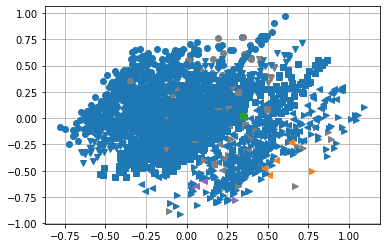

In [34]:
plot2d(X, best_model.labels_, y, mode=PCA)